In [15]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lbc.experiments.runner import SCENARIO_DEFAULT
from lbc.analysis import run_analysis

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
%autoreload 2
from lbc.experiments import (
    DPCRunner, MPCOneShotRunner, MPCRunner, RLCRunner, CPLRunner)

In [17]:
%autoreload
from configs import make_configs

In [19]:
dr = "PC"
configs = make_configs(dr, batch_size=31, lookahead=4)

# MPCOneShot

INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (1/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (2/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (3/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (4/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (5/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (6/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (7/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (8/31)
INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (9/31)
INFO:/Users/dbiagion/gitrepos/learning-buildin

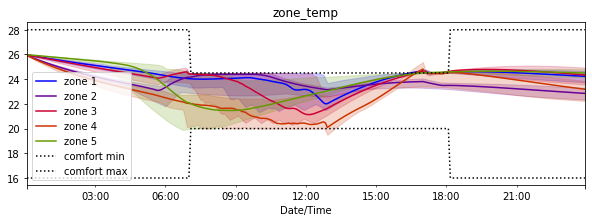

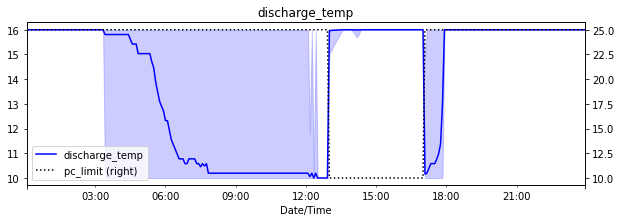

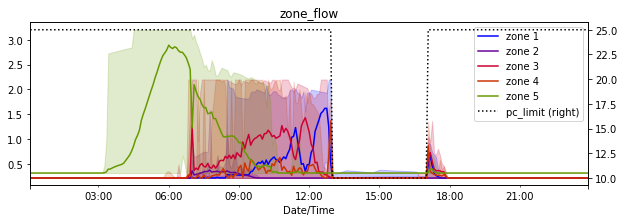

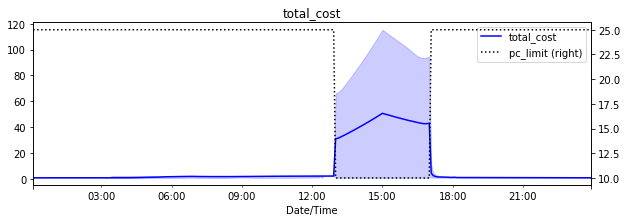

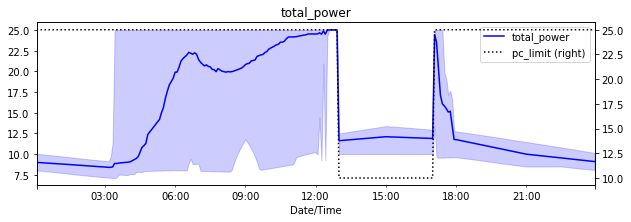

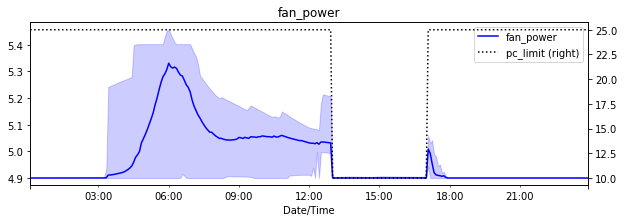

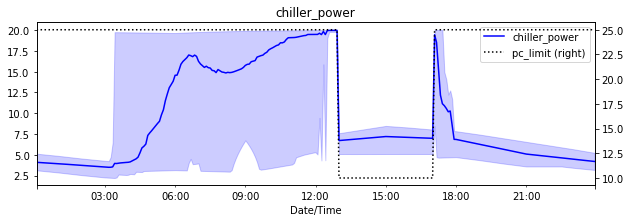

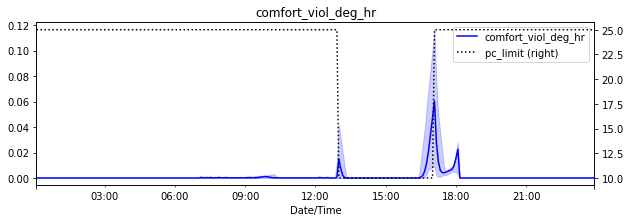

In [20]:
config = configs["MPCOneShot"]

runner0 = MPCOneShotRunner(**config)
loss0, rollout0, meta0 = runner0.run()

_, df, figs = run_analysis(rollout0, dr, secondary=True)

In [21]:
# _ = pd.DataFrame(rollout1.data["predicted_energy_price"]).plot()
# _ = pd.DataFrame(rollout1.data["energy_price"]).plot()

# MPC

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [24:05<00:00,  5.04s/it]
INFO:lbc.experiments.runner:[MPC-PC-test] bsz=31, loss=16.071, time=1445.5
INFO:lbc.experiments.runner:saved to ./_scratch/MPC-PC-test.p


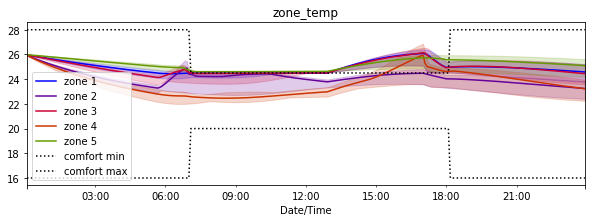

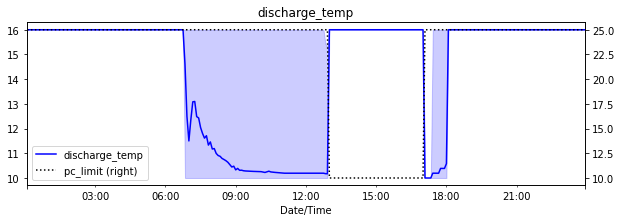

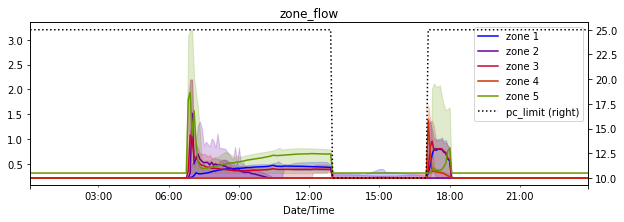

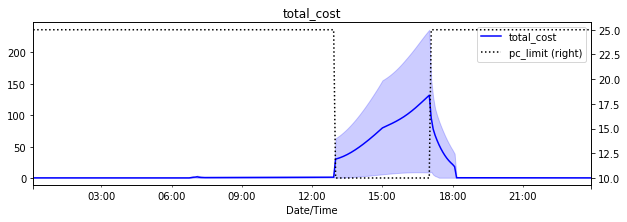

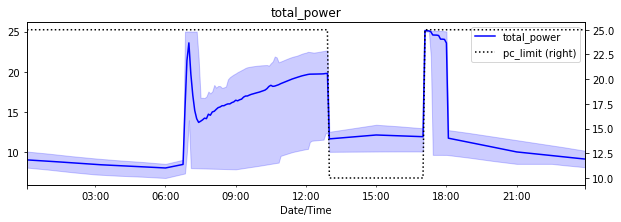

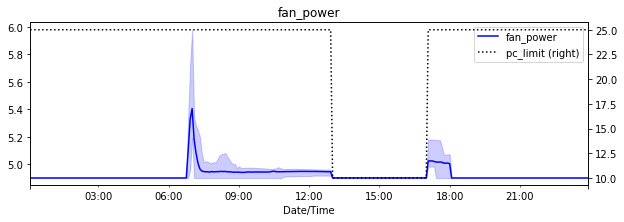

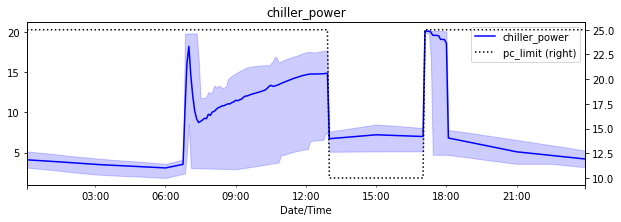

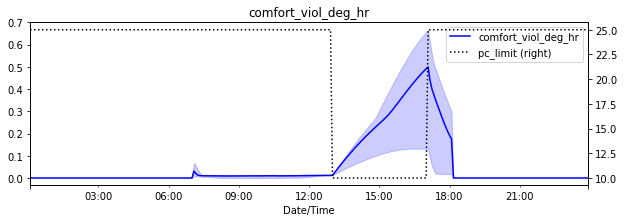

In [22]:
config = configs["MPC"]

runner1 = MPCRunner(**config)
loss1, rollout1, meta1 = runner1.run()

_, df, figs = run_analysis(rollout1, dr, secondary=True)

# CPL - No learning

In [23]:
config = configs["CPL"]
config

{'name': 'CPL-PC-test',
 'policy_type': 'CPL',
 'batch_size': 31,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f89138eae20>},
 'policy_config': {'lookahead': 4,
  'lr': 10,
  'num_epochs': 50,
  'use_value_function': 0,
  'num_time_windows': 24},
 'training': True,
 'dry_run': 0,
 'results_dir': './_scratch'}

/Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/cvxpy/expressions/expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
  0%|                                                                                                            | 0/1 [00:00<?, ?it/s]INFO:lbc.experiments.run_cpl:With use_value_function=False we only run one epoch against the test set. Training loss will be nan here (expected).
/Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you 

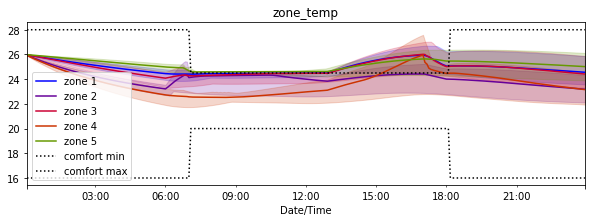

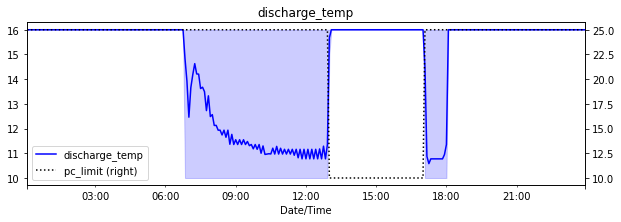

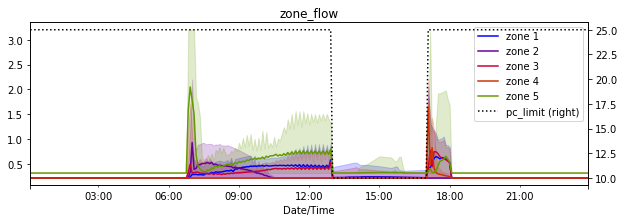

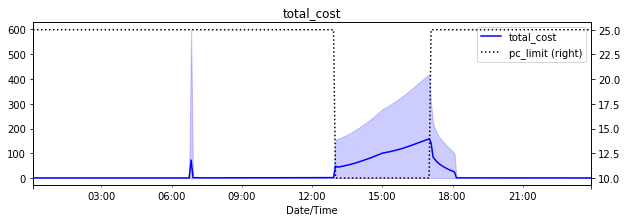

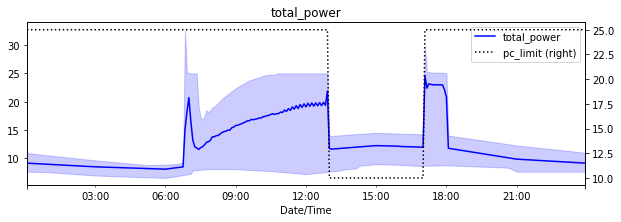

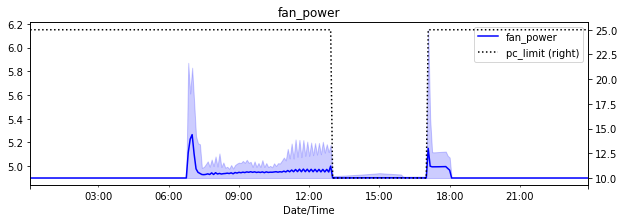

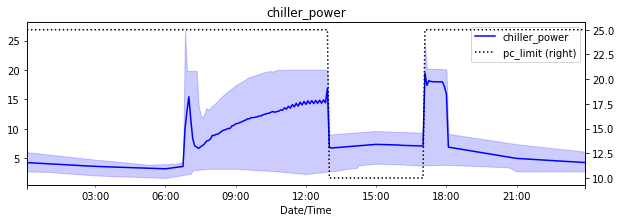

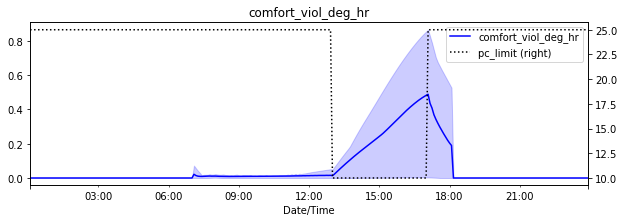

In [24]:
runner2 = CPLRunner(**config)
loss2, rollout2, meta2 = runner2.run()

_, df, figs = run_analysis(rollout2, dr, secondary=True)

# CPL - Learning

In [25]:
config = configs["CPL"]
config["policy_config"]["use_value_function"] = 1
config["policy_config"]["num_epochs"] = 10  # increase this if truly trying to train
config

{'name': 'CPL-PC-test',
 'policy_type': 'CPL',
 'batch_size': 31,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f8504422700>},
 'policy_config': {'lookahead': 4,
  'lr': 10,
  'num_epochs': 10,
  'use_value_function': 1,
  'num_time_windows': 24},
 'training': True,
 'dry_run': 0,
 'results_dir': './_scratch'}

/Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/cvxpy/expressions/expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)
9.126, 13.265 1.000e+01: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [43:09<00:00, 258.98s/it]
INFO:lbc.experiments.runner:[CPL-PC-test] bsz=31, loss=12.738, time=6068.8
INFO:lbc.experiments.runner:saved to ./_scratch/CPL-PC-test.p


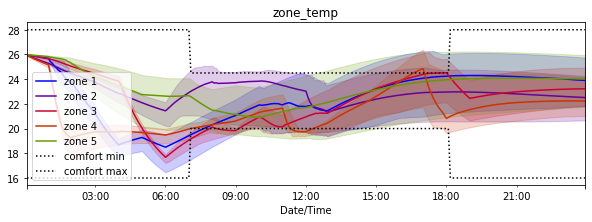

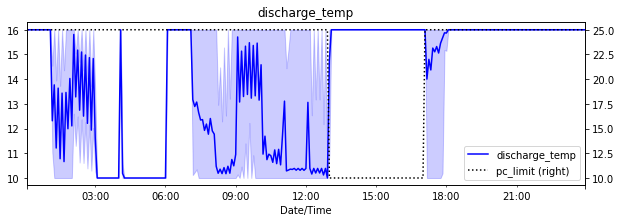

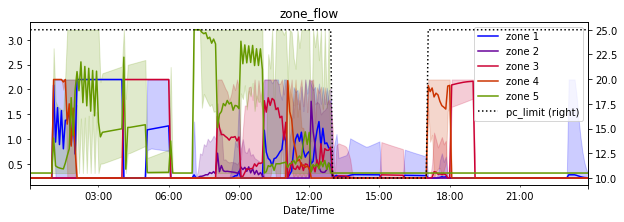

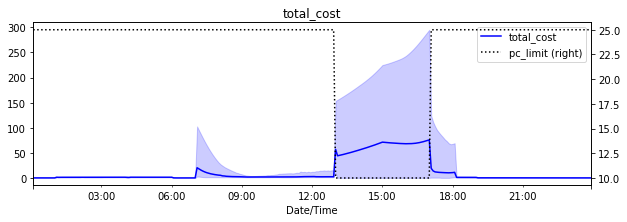

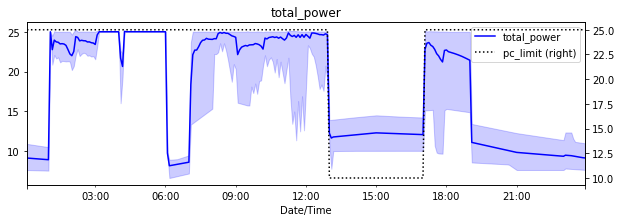

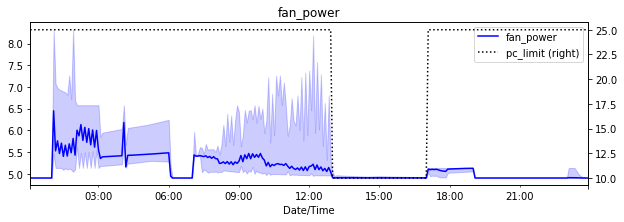

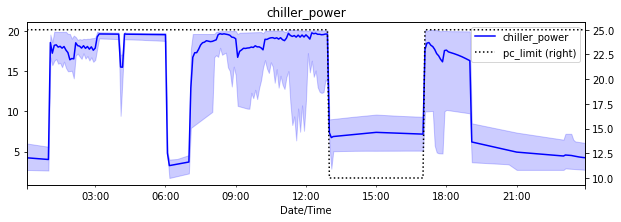

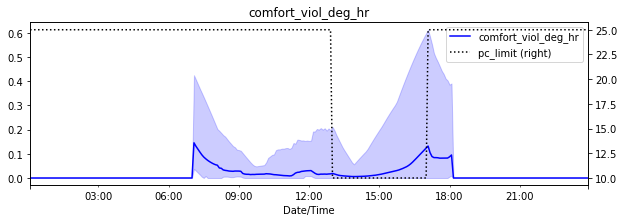

In [26]:
runner3 = CPLRunner(**config)
loss3, rollout3, meta3 = runner3.run()

_, df, figs = run_analysis(rollout3, dr, secondary=True)

# DPC

In [30]:
configs["DPC"]

{'name': 'DPC-PC-test',
 'policy_type': 'DPC',
 'batch_size': 31,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f894292e7c0>},
 'policy_config': {'model_config': {'hidden_dim': 128,
   'num_time_windows': 24,
   'num_episode_steps': 287},
  'lr': 0.001,
  'num_epochs': 500},
 'training': True,
 'dry_run': 0,
 'results_dir': './_scratch'}

5.685, 7.376,:  26%|█████████████████████▏                                                           | 131/500 [03:10<08:57,  1.46s/it]
INFO:lbc.experiments.runner:[DPC-PC-test] bsz=31, loss=7.376, time=191.0
INFO:lbc.experiments.runner:saved to ./_scratch/DPC-PC-test.p


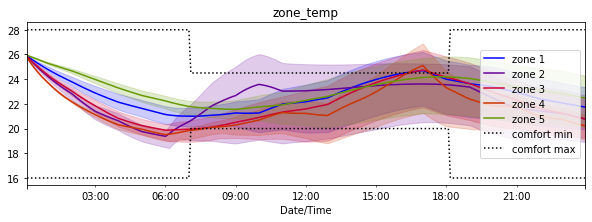

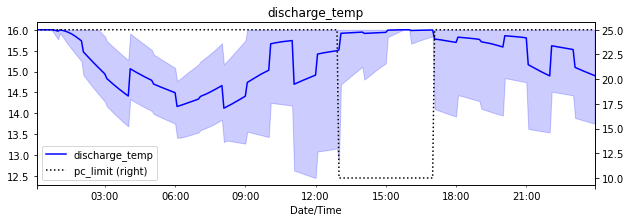

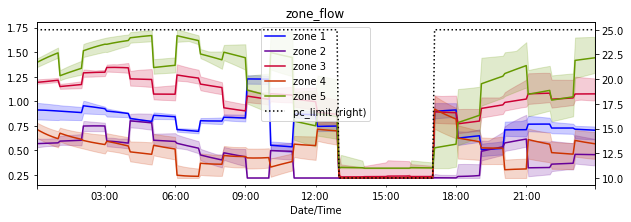

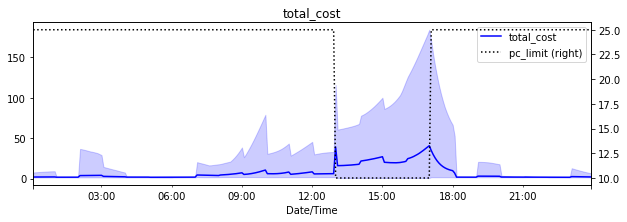

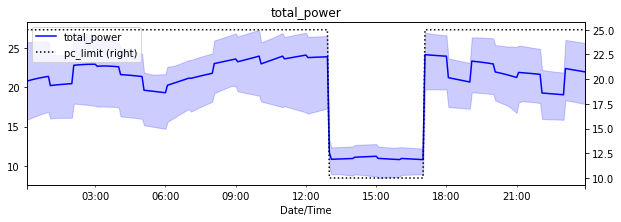

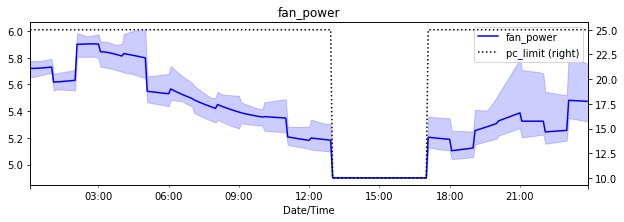

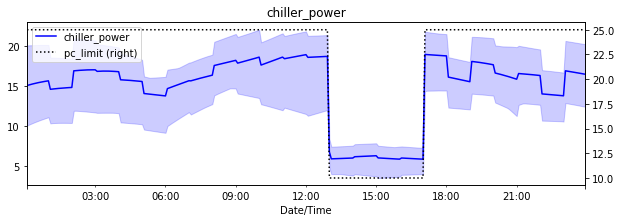

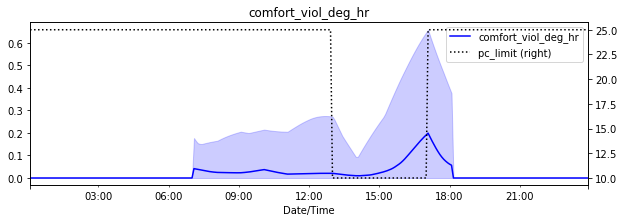

In [31]:
config = configs["DPC"]
config["policy_config"]["num_epochs"] = 500
config["policy_config"]["lr"] = 1e-3

runner4 = DPCRunner(**config)
loss4, rollout4, meta4 = runner4.run()

_, df, figs = run_analysis(rollout4, dr, secondary=True)

# RLC

(RolloutWorker pid=56631) /Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=56631)   logger.warn(
(RolloutWorker pid=56631) 2022-02-10 09:13:31,441	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-02-10 09:13:35,042	INFO trainable.py:124 -- Trainable.setup took 11.552 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-10 09:13:35,045	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-10 09:13:36,053	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: /Users/dbiagion/gitrepos/learning-building-control/lbc/policies/rlc_checkpoints/power_constrained/checkpoint/checkpoint
2022-02-10 09:13:36,097	INFO trainable.py:475 -- Current

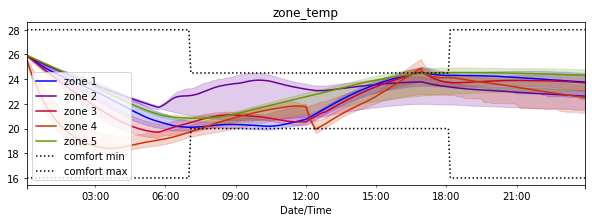

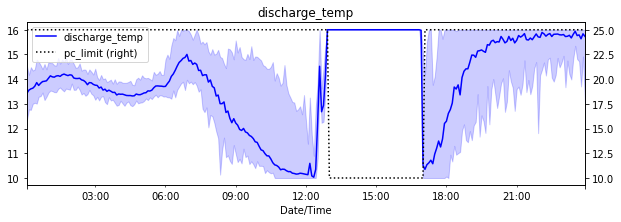

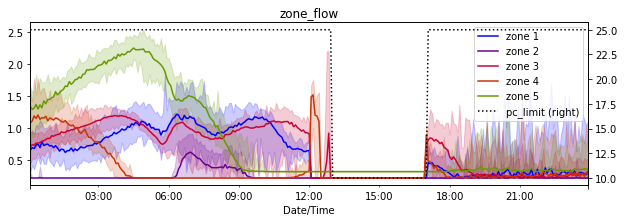

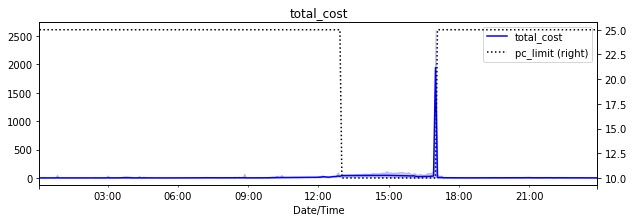

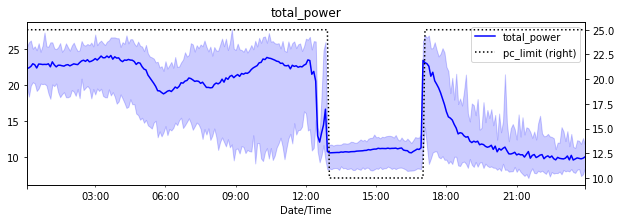

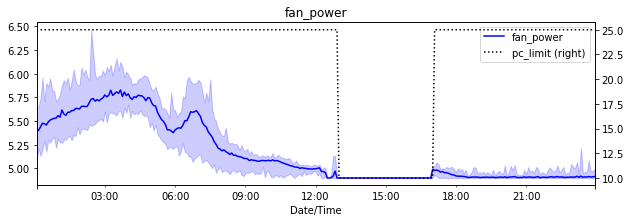

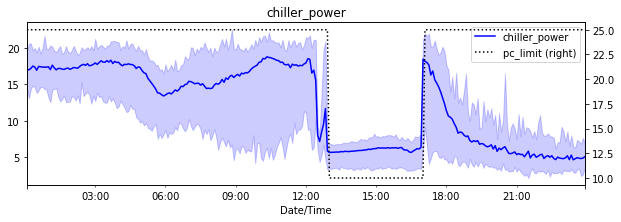

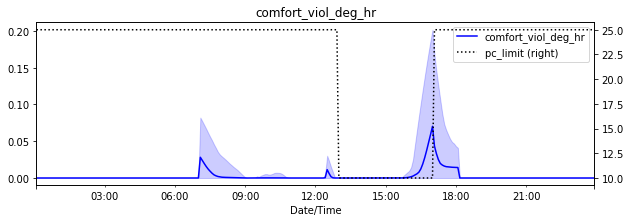

In [32]:
config = configs["RLC"]

# Shut down ray in case it's still running, fail silently
try:
    import ray
    ray.shutdown()
except:
    pass

runner5 = RLCRunner(**config)
loss5, rollout5, meta5 = runner5.run()

_, df, figs = run_analysis(rollout5, dr, secondary=True)